# Table de mortalité

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

Les données sont recensées sur [Data Publica](http://www.data-publica.com/) : [Table de mortalité](http://www.data-publica.com/opendata/7098--population-et-conditions-sociales-table-de-mortalite-de-1960-a-2010) qui les a récupéré depuis le site d'Eurostat via le listing suivant : [listing](http://epp.eurostat.ec.europa.eu/NavTree_prod/everybody/BulkDownloadListing?sort=1&dir=data). Pour faire court, le lien est le suivant : [demo_mlifetable.tsv.gz](http://epp.eurostat.ec.europa.eu/NavTree_prod/everybody/BulkDownloadListing?file=data/demo_mlifetable.tsv.gz). Le fichier est compressé au format [gzip](http://fr.wikipedia.org/wiki/Gzip). On le télécharge, on le décompresse.

In [ ]:
url = "http://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/"
file = "demo_mlifetable.tsv.gz"
import pyensae
local = pyensae.download_data("demo_mlifetable.tsv.gz", url=url)
local = local[0]+".gz"
import gzip
with gzip.open(local, 'rb') as f: file_content = f.read()
content = str(file_content, encoding="utf8")
with open("mortalite.txt", "w", encoding="utf8") as f : f.write(content)

Puis on le charge sous forme de dataframe :

In [ ]:
import pandas
dff = pandas.read_csv("mortalite.txt", sep="\t", encoding="utf8")
dff.head()

,"indic_de,sex,age,geo\time",2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,"DEATHRATE,F,Y1,AL",0.00042 e,:,:,:,:,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
1,"DEATHRATE,F,Y1,AM",:,:,:,:,:,0.00080,0.00067,0.00052,0.00123,...,:,:,:,:,:,:,:,:,:,:
2,"DEATHRATE,F,Y1,AT",0.00015,0.00016,0.00018,0.00018,0.00034,0.00042,0.00039,0.00036,0.00036,...,:,:,:,:,:,:,:,:,:,:
3,"DEATHRATE,F,Y1,AZ",:,0.00070,0.00132,:,0.00134,0.00111,0.00130,0.00187,0.00252,...,:,:,:,:,:,:,:,:,:,:
4,"DEATHRATE,F,Y1,BE",0.00035,0.00036,0.00025,0.00030,0.00021,0.00041,0.00030,0.00039,0.00035,...,0.00141,0.00155,0.00132,0.00129,0.00153,0.00137,0.00170,0.00161,0.00168,0.00159


In [ ]:
dff.shape

(95718, 56)

La première colonne contient une aggrégation de champs. On souhaite transformer cette table de telle sorte qu'on ait un nombre réduit de colonnes :

- indicateur
- genre
- age
- pays (ou ensemble de pays)
- annee
- valeur

L'âge est représenté sous forme de chaîne de caractères pour pouvoir écrire ``Y_LT1`` (moins d'un an), ``Y_GE85`` (plus de 85 ans). On change un peu le format pour pouvoir les trier par ordre croissant (en effet ``Y2`` est après ``Y10``). On sauve le tout dans un fichier pour ne pas avoir à recommencer ultérieurement. Malgré tout, le code ci-dessous est très lent pour la table complète qui contiendra au final près de 5 millions de lignes. On supprime les valeurs manquantes.

In [ ]:
def format_age(s):
    if s.startswith("Y_") : 
        if s.startswith("Y_LT"): s = "Y00_LT" + s[4:]
        elif s.startswith("Y_GE"): s = "Y85_GE" + s[4:]
        else: raise FormatError(s)
    else:
        i = int(s.strip("Y"))
        return "Y%02d" % i
    
def format_value(s):
    if s.strip() == ":" : return -1
    else : return float(s.strip(" ebp"))
    
if False:  # sur les données complètes, c'est plutôt long, réduire la taille pour essayer
    dfsmall = dff.head(n = 1000) # on réduit la taille pour 
    df = dfsmall # implémenter la transformation
else:
    df = dff

print("étape 1", df.shape)
dfi = df.reset_index().set_index("indic_de,sex,age,geo\\time")
dfi = dfi.drop('index', axis=1)
dfs = dfi.stack()
dfs = pandas.DataFrame({"valeur": dfs } )

print("étape 2", dfs.shape)
dfs["valeur"] = dfs["valeur"].astype(str)
dfs["valeur"] = dfs["valeur"].apply( format_value )
dfs = dfs[ dfs.valeur >= 0 ].copy()
dfs = dfs.reset_index()
dfs.columns = ["index", "annee", "valeur"]

print("étape 3", dfs.shape)
dfs["age"] = dfs["index"].apply ( lambda i : format_age(i.split(",")[2]))
dfs["indicateur"] = dfs["index"].apply ( lambda i : i.split(",")[0])
dfs["genre"] = dfs["index"].apply ( lambda i : i.split(",")[1])
dfs["pays"] = dfs["index"].apply ( lambda i : i.split(",")[3])

print("étape 4")
dfy = dfs.drop('index', axis=1)
dfy.to_csv("mortalite_5column.txt", sep="\t", encoding="utf8", index=False)
dfy.head()

étape 1 (95718, 56)
étape 2 (5264490, 1)
étape 3 (2770815, 3)
étape 4


,annee,valeur,age,indicateur,genre,pays
0,2014,0.00042,Y01,DEATHRATE,F,AL
1,2009,0.00080,Y01,DEATHRATE,F,AM
2,2008,0.00067,Y01,DEATHRATE,F,AM
3,2007,0.00052,Y01,DEATHRATE,F,AM
4,2006,0.00123,Y01,DEATHRATE,F,AM


Graphe d'une coupe de la table de mortalité :

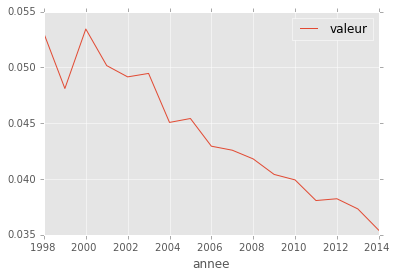

In [ ]:
view = dfs [    (dfs.pays=="FR") &
                (dfs.age == "Y80") &
                (dfs.indicateur == "DEATHRATE") &
                (dfs.genre == "T")  ]
view = view.sort_values("annee")
view.plot(x="annee", y="valeur")

### SQLite

[SQLite](http://www.sqlite.org/) est un outils de gestion de base de données locales. Intégré à Python, il ne nécessite aucune installation. Il est très utile lorsque [Microsoft Excel](http://fr.wikipedia.org/wiki/Microsoft_Excel) ne peut pas contenir toutes les données qu'on souhaite consulter. Plus de deux millions de lignes dans le cas de cette table.

### version 1 : pandas to SQLite

On utilise pour la méthode [to_sql](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.to_sql.html) et le module [sqlite3](https://docs.python.org/3.4/library/sqlite3.html). Ca prend un peu de temps (deux à trois minutes).

In [ ]:
import sqlite3
con = sqlite3.connect("mortalite_sqlite3_y.db3")
dfy.to_sql("table_mortalite",con)
con.close()  # il faut fermer la base qui sinon reste ouverte tant que le notebook
             # n'est pas fermé --> elle n'est pas modifiable pas d'autre que ce notebook

In [ ]:
import os
[ _ for _ in os.listdir(".") if "sqlite3" in _ ]

['mortalite_sqlite3_y.db3']

On utilise une requête SQL pour récupérer les données équivalent au code pandas cité ci-dessous :

In [ ]:
con = sqlite3.connect("mortalite_sqlite3_y.db3")
view = pandas.read_sql("""SELECT * FROM table_mortalite WHERE pays=="FR" 
            AND age == "Y80" 
            AND indicateur == "DEATHRATE"
            AND genre == "T"
            ORDER BY annee""", con)
con.close()

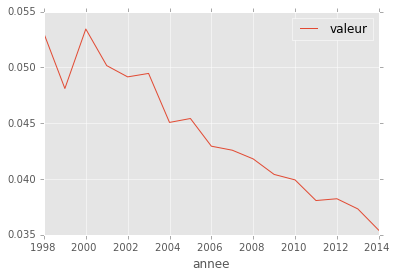

In [ ]:
view.plot(x="annee", y="valeur")

### version 2 : pyensae

[import_flatfile_into_database](http://www.xavierdupre.fr/app/pyensae/helpsphinx/pyensae/sql/database_helper.html) est une fonction à utiliser lorsqu'on ne sait pas toujours quel est le séparateur de colonnes dans le fichier à importer. La fonction le devine pour vous ainsi que le type de chaque colonne (quand c'est possible). L'autre aspect intéressant est qu'elle affiche son état d'avancement. On repère plus rapidement que quelque chose se passe mal. Enfin, pour les gros fichiers, la fonction ne charge pas tout le fichier en mémoire. Cela permet de placer dans une base SQLite des milliards de lignes (cela peut prendre plus d'une heure). Ce n'est pas le cas ici, c'est juste à titre d'exemple. On stocke l'ensemble des données au format SQLite 3 de façon à pouvoir les consulter plus facilement.

In [ ]:
from pyensae.sql import import_flatfile_into_database
import_flatfile_into_database("mortalite.db3", "mortalite_5column.txt")

  TextFile: opening file  mortalite_5column.txt
  TextFile.guess_columns: processing file  mortalite_5column.txt
  TextFile: opening file  mortalite_5column.txt
  TextFile.guess_columns: using  101  lines
  TextFile: closing file  mortalite_5column.txt
  TextFile.guess_columns: sep  '\t' nb cols 6  bestnb  101  more  {('\t', 5): 101, (' ', 1): 100}
  TextFile.guess_columns: header  True  columns  {0: ('annee', <class 'int'>), 1: ('valeur', <class 'float'>), 2: ('age', <class 'str'>), 3: ('indicateur', <class 'str'>), 4: ('genre', <class 'str'>), 5: ('pays', <class 'str'>)}
  compiling ^(?P<annee>([-]?[1-9][0-9]*?)|(0?))\t(?P<valeur>[-]?[0-9]*?([.][0-9]*?)?([eE][-]?[0-9]{0,4})?)\t(?P<age>.*)\t(?P<indicateur>.*)\t(?P<genre>.*)\t(?P<pays>.*)$
  TextFile.guess_columns: regex  ^(?P<annee>([-]?[1-9][0-9]*?)|(0?))\t(?P<valeur>[-]?[0-9]*?([.][0-9]*?)?([eE][-]?[0-9]{0,4})?)\t(?P<age>.*)\t(?P<indicateur>.*)\t(?P<genre>.*)\t(?P<pays>.*)$
  TextFile.guess_columns: header  True  columns  {0: ('anne

Ensuite, on peut facilement consulter les données avec le logiciel (sous Windows) [SQLiteSpy](http://www.yunqa.de/delphi/doku.php/products/sqlitespy/index) ou l'extension [sqlite-manager](https://addons.mozilla.org/fr/firefox/addon/sqlite-manager/) pour Firefox sous toutes les plates-formes. Pour cet exercice, on exécute :

In [ ]:
sql = """SELECT * FROM mortalite_5column WHERE pays=="FR" 
            AND age == "Y80" 
            AND indicateur == "DEATHRATE"
            AND genre == "T"
            ORDER BY annee"""
from pyensae.sql import Database
db = Database("mortalite.db3", LOG = lambda *l : None)
db.connect()
view = db.to_df(sql)
view

,annee,valeur,age,indicateur,genre,pays
0,1998,0.05303,Y80,DEATHRATE,T,FR
1,1999,0.04811,Y80,DEATHRATE,T,FR
2,2000,0.05344,Y80,DEATHRATE,T,FR
3,2001,0.05016,Y80,DEATHRATE,T,FR
4,2002,0.04915,Y80,DEATHRATE,T,FR
5,2003,0.04946,Y80,DEATHRATE,T,FR
6,2004,0.04507,Y80,DEATHRATE,T,FR
7,2005,0.04542,Y80,DEATHRATE,T,FR
8,2006,0.04294,Y80,DEATHRATE,T,FR
9,2007,0.04258,Y80,DEATHRATE,T,FR


Visuellement, cela donne :

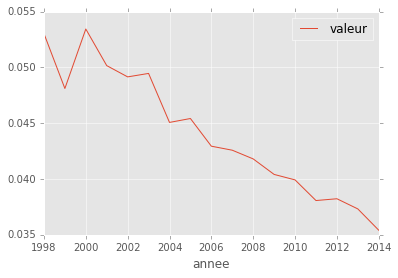

In [ ]:
view.plot(x="annee", y="valeur")

## Cube de données

On utilise l'expression *cube de données* pour désigner à tableaux à plusieurs dimensions. On le représente souvent par une liste ``coordonnées, valeurs``. C'est souvent beaucoup de données et pas forcément de moyen pratique de les manipuler. 

module xarray

In [ ]:
import pandas 
df = pandas.read_csv("mortalite_5column.txt", sep="\t", encoding="utf8")
df.shape

(2770815, 6)